In [1]:
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
import pprint

In [2]:
def make_dataset_grid(dataset, n_samples, random_seed=0, label_idx_to_name=None):
    """Make a grid of n_samples from a dataset."""
    n_samples_sqrt = int(np.ceil(np.sqrt(n_samples)))
    n_samples = n_samples_sqrt ** 2  # alter n_samples to a number that is a perfect square

    rng = np.random.RandomState(random_seed)
    indices = rng.choice(len(dataset), size=n_samples, replace=False)
    fig, axes = plt.subplots(n_samples_sqrt, n_samples_sqrt, figsize=(n_samples_sqrt*3, n_samples_sqrt*3))
    axes = axes.flatten()
    for ax, sample_idx in zip(axes, indices):
        output = dataset[sample_idx]
        x, y = np.array(output[0]), output[1]
        if x.ndim == 2:
            ax.imshow(x, cmap='gray')
        else:
            if x.ndim == 3:
                if x.shape[0] == 3:
                    x = np.moveaxis(x, 0, -1)
            ax.imshow(x)
        ax.set_title(label_idx_to_name[y] if label_idx_to_name is not None else y)
        ax.axis('off')
    plt.tight_layout()
    return fig, axes

In [3]:
#### TEMP ####
import sys
sys.path.append('..')
#### TEMP ####

from sc2image.dataset import StarCraftImage, StarCraftCIFAR10, StarCraftMNIST

data_dir = Path('..') / 'data'
data_dir = Path('..') / 'temp_data'

# Load the datasets.
There are three main StarCraftII datasets. 
Each dataset includes images summarize a 10 second window (255 frames) of a StarCraftII replay.

1. `StarCraftImage`: This is the main dataset which includes multiple image formats:`'sparse-hyperspectral'`, `'dense-hyperspectral'`, `'bag-of-units'`, `'bag-of-units-first'`, and contains all unit positioning information throughout the window.

2. `StarCraftCIFAR10`: This is a simplified version of the `StarCraftImage` dataset which exactly matches the setup of the CIFAR10 dataset.
To do this, all images have been condensed into a three channel (RGB) image.
 Each pixel value corresponds to the last seen timestamps for any unit at that pixel location, 
 where the Red channel corresponds to Player 2 units, Green correspond to neutral units, and Blue to Player 1 units.
 The 10 classes can be seen below, and equates to: `(map_name, did_window_happen_in_first_half_of_replay)`
 
 3. `StarCraftMNIST`: This is a further simplified version of the `StarCraftImage` dataset which exactly matches the setup of the MNIST dataset. 
 The pixel values also correspond to the last seen timestamps for units at that pixel location (with a player-specific scaling applied), and the 10 classes match that of `StarCraftCIFAR10`.

In [4]:
from sc2image.dataset import _DEFAULT_10_LABELS_DICT
print('The 10 class labels are:')
pprint.pprint(_DEFAULT_10_LABELS_DICT)  # pretty prints the label dictionary

The 10 class labels are:
{0: ('Acolyte LE', 'Beginning'),
 1: ('Acolyte LE', 'End'),
 2: ('Abyssal Reef LE', 'Beginning'),
 3: ('Abyssal Reef LE', 'End'),
 4: ('Ascension to Aiur LE', 'Beginning'),
 5: ('Ascension to Aiur LE', 'End'),
 6: ('Mech Depot LE', 'Beginning'),
 7: ('Mech Depot LE', 'End'),
 8: ('Odyssey LE', 'Beginning'),
 9: ('Odyssey LE', 'End')}


### Loading in the simplified datasets

Files already downloaded and verified


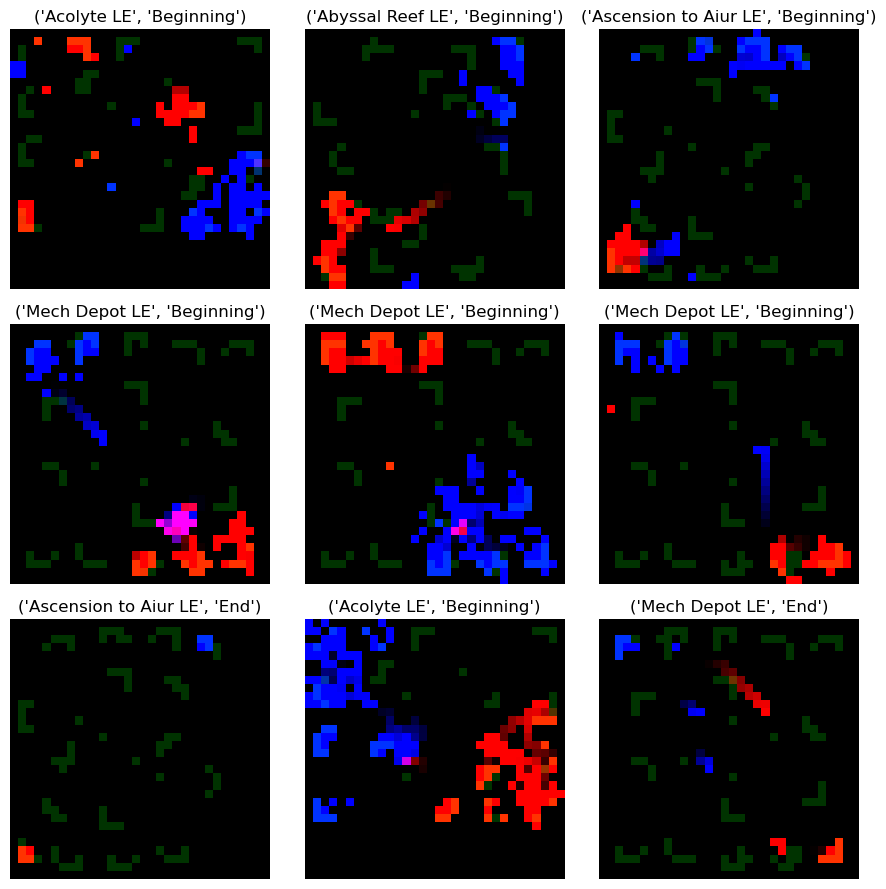

In [5]:
cifar = StarCraftCIFAR10(data_dir, train=True, download=True)
make_dataset_grid(cifar, n_samples=9, label_idx_to_name=_DEFAULT_10_LABELS_DICT)
plt.show()

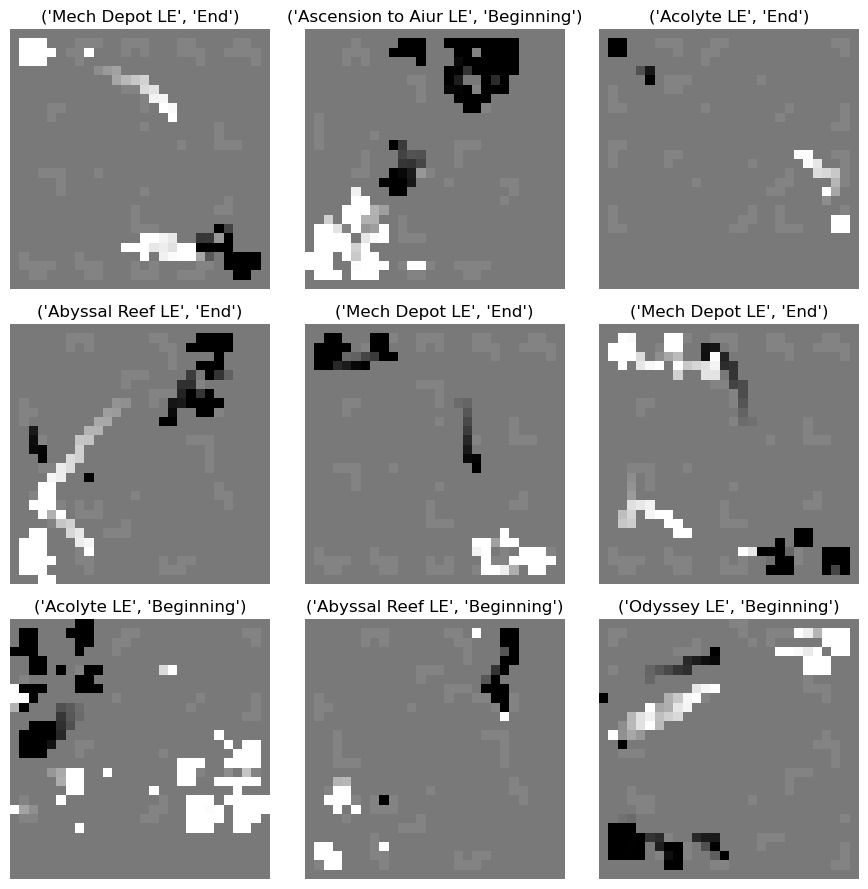

In [6]:
mnist = StarCraftMNIST(data_dir, train=True, download=True)
make_dataset_grid(mnist, n_samples=9, label_idx_to_name=_DEFAULT_10_LABELS_DICT)
plt.show()

### Loading in the StarCraftImage dataset

This dataset is the most expressive dataset and includes all unit positioning information throughout the window.
There are two main types of image formats used (here `image_size` is a hyperparameter that can be set by the user and has a default value of 64):  

- Hyperspectral images: This is hyperspectral image with shape (384,``image_size``,``image_size``), where each channel 
corresponds to a player_id+unit_id combination and the value at each location is the last time a unit was seen at that location during the window.
The first 170 channels correspond to Player 1 units, the next 170 channels correspond to Player 2 units, and the last 44 channels correspond to neutral units.
For example, if `hyperspectral_image[51, 10, 4]=244` this means Player 1's Terran Battlecruiser was last seen at pixel location (51, 10) at the 244th time step (out of 255 time steps).

- Bag of units images: This condensed version of the hyperspectral images and is a tuple of images corresponding to (unit_ids, unit_values) which each has shape (3, `C`, ``image_size``,``image_size``), where the first axis corresponds to `(player_1_channels, player_2_channels, neutral_channels)` and `C` is the number of overlapping units at any one location and is *window-specific*.
The unit_ids image is an image where each pixel value corresponds to the unit_id at that pixel location and unit_values is an image where each pixel value corresponds to the last seen timestamps for the corresponding unit at that pixel location.
For example, if `unit_ids[2, 3, 10, 4]=51` and `unit_values[2, 3, 10, 4]=244`, this means Player 2's Terran Battlecruiser was last seen at pixel location (51, 10) at the 244th time step.

With this in mind, we can quickly go over the different image formats that are available.
1. `'dense-hyperspectral'`: This is the default image format and returns a hyperspectral image as a pytorch tensor.
2. `'sparse-hyperspectral'`: This return a hyperspectral image as a sparse COO pytorch tensor
3. `'bag-of-units'`: This is a bag of units image and returns tuple of (unit_ids_bag, unit_values_bag).
4. `'bag-of-units-first'`: This returns tuple of (unit_ids_bag, unit_values_bag) where both elements
                always have shape (3, `image_size`,`image_size`), and is equivalent to only returning the first
                overlapping dimension of the `bag-of-units` representation for each player.


In [8]:
for image_format in ['dense-hyperspectral', 'sparse-hyperspectral', 'bag-of-units', 'bag-of-units-first']:
    scimage = StarCraftImage(data_dir, image_format=image_format,
                             train=True, download=True, use_metadata_cache=True, verbose=False)
    print(f'\nFor image format `{image_format}`:')
    print(f'\tThe output image type is: {type(scimage[0])}')
    print(f'\tThe output image(s) have shape: {[im.shape for im in scimage[0]] if isinstance(scimage[0], tuple) else scimage[0].shape}')
    print(f'\tThe output image(s) have dtype: {[im.dtype for im in scimage[0]] if isinstance(scimage[0], tuple) else scimage[0].dtype}')
    print()

  0%|          | 0/10914999592 [00:00<?, ?it/s]

Extracting ../temp_data/starcraft-image-dataset_v1_0/starcraftimage.tar.gz to ../temp_data/starcraft-image-dataset_v1_0
No cached metadata found at  ../temp_data/starcraft-image-dataset_v1_0/cached-metadata.pkl
Loading metadata from csv and saving to cache

For image format `dense-hyperspectral`:
	The output image type is: <class 'torch.Tensor'>
	The output image(s) have shape: torch.Size([384, 64, 64])
	The output image(s) have dtype: torch.uint8


For image format `sparse-hyperspectral`:
	The output image type is: <class 'torch.Tensor'>
	The output image(s) have shape: torch.Size([384, 64, 64])
	The output image(s) have dtype: torch.uint8


For image format `bag-of-units`:
	The output image type is: <class 'tuple'>
	The output image(s) have shape: [torch.Size([3, 3, 64, 64]), torch.Size([3, 3, 64, 64])]
	The output image(s) have dtype: [torch.uint8, torch.uint8]


For image format `bag-of-units-first`:
	The output image type is: <class 'tuple'>
	The output image(s) have shape: [torch

### Additional return options for StarCraftImage dataset
In addition to the image formats, there are also additional return options that can be set by the user:
- `return_label`: If set to `True`, this returns the classification label for the window which corresponds to the `(map_name, did_window_happen_in_first_half_of_replay)`.
 This also requires specifying `label_kind` which can either be set to `14 class` (which includes all 7 maps) or `10 class` (which only includes samples from the five most popular maps).
 
 - `return_dict`: If set to `True`, this returns a dictionary which includes metadata related to that sample.
 The metadata included in the dictionary is: the map state for each player (`player_X_is_seen`, `player_X_is_visible`,
 `player_X_creep`), replay metadata (e.g., number of windows, player races, map name, player tabular information), terrain information (`pathing grid`, `placement_grid`, `terrain_height`), and a vector of player tabular information (`player_X_tabular`).

In [ ]:
# Adding return_label=True
scimage = StarCraftImage(data_dir, return_label=True, label_kind='14-class',
                         use_metadata_cache=True, verbose=False)
output = scimage[0]
print(f'There are now {len(output)} outputs, and the output label is: {output[1]}')

There are now 2 outputs, and the output label is: 5


In [ ]:
# Adding return_dict=True
scimage = StarCraftImage(data_dir, return_dict=True,
                         return_label=True, label_kind='14-class', use_metadata_cache=True, verbose=False)
output = scimage[0]
print(f'There are now {len(output)} outputs, and the output dict has keys: \n{output[-1].keys()}\nAnd entries:')
pprint.pprint(output[-1])  # pretty prints the image metadata

There are now 3 outputs, and the output dict has keys: 
dict_keys(['player_1_is_visible', 'player_1_is_seen', 'player_1_creep', 'player_2_is_visible', 'player_2_is_seen', 'player_2_creep', 'pathing_grid', 'placement_grid', 'terrain_height', 'player_1_tabular', 'player_2_tabular', 'metadata'])
And entries:
{'metadata': {'10_class_data_split': 'train',
              '14_class_data_split': 'train',
              'game_duration_seconds': 765.8123779296875,
              'global_idx': 3050830,
              'map_name': 'Ascension to Aiur LE',
              'num_windows': 67,
              'player_1_apm': 228,
              'player_1_army_count': 0,
              'player_1_food_army': 0,
              'player_1_food_cap': 15,
              'player_1_food_used': 15,
              'player_1_food_workers': 14,
              'player_1_idle_worker_count': 0,
              'player_1_larva_count': 0,
              'player_1_minerals': 45,
              'player_1_mmr': 5597,
              'player_1_